In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Initialize parameters of problem

In [2]:
T=100 # time horizon
h=1 # time step

mass=100
l=70 # length of rocket
I=mass*l**2

m=6  #dimension of state
n=2  #dimension of input

#state is [x,y,xdot,ydot,phi,phidot]

# Set initial state and desired target state
x0=np.array([0,5000,10,0,np.pi/2,0])
target=np.array([1750,0,0,0,0,0])
    

q=np.array([1,1,1,1,50,50])
Q=10**10*np.diag(q)
R=1*np.eye(n)

## Functions

In [3]:
def step(x,u):
    #control is [Force,theta]
    F,theta=u
    phi=x[4]
    x1=np.copy(x)
    
    x1[0]+=h*x[2]
    x1[1]+=h*x[3]
    x1[2]+=(h*F/mass)*np.sin(theta+phi)
    x1[3]+=h*(-1+(F/mass)*np.cos(theta+phi))
    x1[4]+=h*x[5]
    x1[5]+= -(h*F*l)/(2*I)*np.sin(theta)
    return after_step(x1)
def after_step(x):
    x[4]=np.arctan2(np.sin(x[4]),np.cos(x[4]))
    return x
def adjust_control(u):
    u[1]=np.arctan2(np.sin(u[1]),np.cos(u[1]))
    return u
def Q_constraint(x,u):
    Qt=np.zeros((m,m))
    Qt[1,1]=np.exp(-1*x[1])
    return Qt
def linearize(x,u):
    F,theta=u
    phi=x[4]
    
    A=np.eye(m)
    B=np.zeros((m,n))
    
    A[0,2]=h
    A[1,3]=h
    A[4,5]=h
    A[2,4]= (h*F/mass)*np.cos(theta+phi)
    A[3,4]= -(h*F/mass)*np.sin(theta+phi)
    
    B[2,0]=(h/mass)*np.sin(theta+phi)
    B[2,1]=(h*F/mass)*np.cos(theta+phi)
    B[3,0]=(h/mass)*np.cos(theta+phi)
    B[3,1]=(h*F/mass)*-1*np.sin(theta+phi)
    B[5,0]=((-h*l)/(2*I))*np.sin(theta)
    B[5,1]=-((h*F*l)/(2*I))*np.cos(theta)
    
    return A,B,R
def forwardpass(oldx_s,oldu_s,control_list,T,alpha=1,initial=False):
    x_s=np.zeros((T,m))
    x_s[0]=oldx_s[0]
    u_s=np.zeros((T-1,n))
    
    for i in range(T-1):
        K,Kv,v,Ku=control_list[i]
        if initial:
            u_s[i]=adjust_control(oldu_s[i])
        else:
            u_s[i]=adjust_control(oldu_s[i]-np.dot(K,x_s[i]-oldx_s[i])-alpha*np.dot(Kv,v)-alpha*np.dot(Ku,oldu_s[i]))
    
        #Clamp constraints
        if u_s[i][0]>10000:
            u_s[i]=10000
        elif u_s[i][0]<0:
            u_s[i]=0
        
        x_s[i+1]=step(x_s[i],u_s[i])
    return x_s,u_s
def backpass(x_s,u_s,T):
    S=np.zeros((T,m,m))
    v=np.zeros((T,m))
    K=np.zeros((T-1,n,m))
    Kv=np.zeros((T-1,n,m))
    Ku=np.zeros((T-1,n,n))
    
    control_list=[]
    for i in range(T-1,-1,-1):
        if i==T-1:
            S[i]=Q
            v[i]=np.dot(Q,x_s[i]-target)
        else:
            Qt=Q_constraint(x_s[i],u_s[i])
            A,B,R=linearize(x_s[i],u_s[i])
            factor = np.linalg.inv(B.T@S[i+1]@B+R)
            K[i]=factor@B.T@S[i+1]@A
            Kv[i]=factor@B.T
            Ku[i]=factor@R
            S[i]=A.T@S[i+1]@(A-B@K[i]) +Qt
            v[i]=np.dot((A-B@K[i]).T,v[i+1])-np.dot(K[i].T@R,u_s[i]) +np.dot(Qt,x_s[i])
            control_list.insert(0,(K[i],Kv[i],v[i+1],Ku[i]))
    return control_list
def adjust_control_list(control_list,alpha):
    N=len(control_list)
    new_control_list=[]
    for i in range(N):
        new_control_list.append((control_list[i][0],alpha*control_list[i][1],control_list[i][2],alpha*control_list[i][3]))
    return new_control_list
def cost(x_s,u_s,T):
    cost=(x_s[-1]-target).T@Q@(x_s[-1]-target)
    for i in range(T-1):
        cost += u_s[i].T@R@u_s[i]
    return cost
def solve(x0,iters,T,verbal=False,u_guess=np.zeros((T-1,n))):
    x_s=np.zeros((T,m))
    x_s[0]=x0
    control_list = [(np.zeros((n,m)), np.zeros((n,m)),np.zeros(m),np.zeros((n,n))) for _ in range(T-1)]
    u_s=u_guess
    for i in range(iters):
        x_s,u_s=forwardpass(x_s,u_s,control_list,T,initial=(i==0))
        new_control_list=backpass(x_s,u_s,T)
        current_cost=cost(x_s,u_s,T)
        alpha=1
        newx_s,newu_s=forwardpass(x_s,u_s,new_control_list,T,alpha=alpha)
        while(current_cost<cost(newx_s,newu_s,T) and alpha>=10**-30):
            alpha/=2
            newx_s,newu_s=forwardpass(x_s,u_s,new_control_list,T,alpha=alpha)
        
        if(cost(newx_s,newu_s,T)>500*current_cost):
            if verbal:
                print(cost(newx_s,newu_s,T),cost(x_s,u_s,T),"cost jumped too much")
            return control_list,x_s,u_s
        control_list=adjust_control_list(new_control_list,alpha)
        if verbal:
            print(cost(x_s,u_s,T))
    x_s,u_s=forwardpass(x_s,u_s,control_list,T)
    return control_list,x_s,u_s

def solve_mpc(x0,iters,T,verbal=False,u_guess=np.zeros((T-1,n))):
    final_x_s=np.zeros((T,m))
    final_x_s[0]=x0
    final_u_s=np.zeros_like(u_guess)
    
    for i in range(T-1):
        control_list,x_s,u_s=solve(x0,iters,T-i,verbal=verbal,u_guess=u_guess)
        final_x_s[i+1]=x_s[1]
        final_u_s[i]=u_s[0]
        x0=final_x_s[i+1]
        u_guess=u_s[1:]
    
    return final_x_s,final_u_s

def plot(x_s,u_s):
    fig=plt.figure(figsize=(12,12))
    rows=3
    columns=3

    fig.add_subplot(rows,columns,1)
    plt.plot(x_s[:,0])
    plt.title("X coordinate")

    fig.add_subplot(rows,columns,2)
    plt.plot(x_s[:,1])
    plt.title("Y coordinate")

    fig.add_subplot(rows,columns,3)
    plt.plot(x_s[:,2])
    plt.title("X velocity")

    fig.add_subplot(rows,columns,4)
    plt.plot(x_s[:,3])
    plt.title("Y velocity")

    fig.add_subplot(rows,columns,5)
    plt.plot(x_s[:,4])
    plt.title("Angle")

    fig.add_subplot(rows,columns,6)
    plt.plot(x_s[:,5])
    plt.title("Angular velocity")
    
    fig.add_subplot(rows,columns,7)
    plt.plot(u_s[:,0])
    plt.title("Force used")

    fig.add_subplot(rows,columns,8)
    plt.plot(u_s[:,1])
    plt.title("Nozzle angle")

def plotpath(x_s,u_s,thrust=False):
    fig=plt.figure(figsize=(12,12))
    plt.plot(x_s[:,0],x_s[:,1])
    plt.quiver(x_s[:,0],x_s[:,1],np.sin(x_s[:,4]),np.cos(x_s[:,4]),color='b',label="Rocket orientation")
    if thrust:
        plt.quiver(x_s[:-1,0],x_s[:-1,1],np.sin(x_s[:-1,4]+u_s[:,1]),np.cos(x_s[:-1,4]+u_s[:,1]),label="Rocket thrust")
    plt.title("Path taken")
    plt.grid()
    plt.legend()
    plt.show()

# Algorithm 1: iLQR

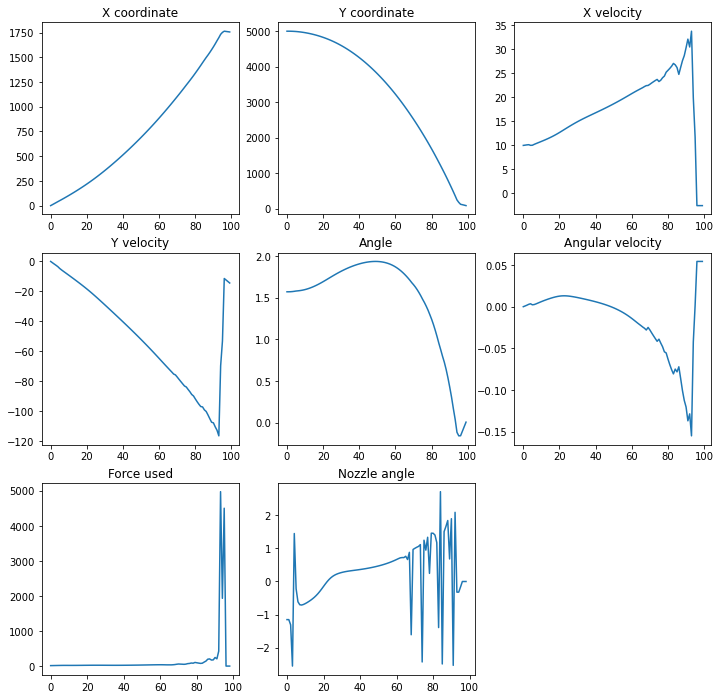

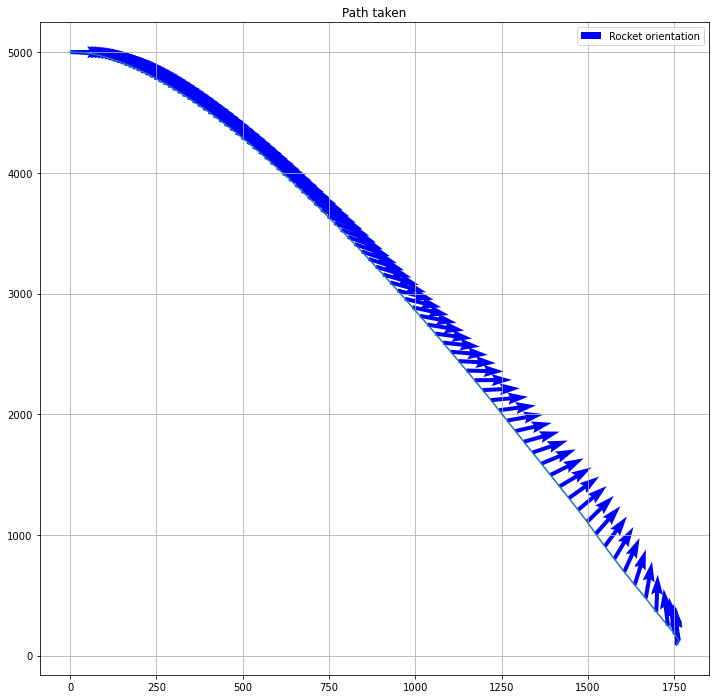

In [4]:
# Set initial guess
u_guess=np.zeros((T-1,n))
u_guess[:,0]=20 

# Set number of iterations
iters=50
control_list,x_s,u_s=solve(x0,iters,T,verbal=False,u_guess=u_guess)
plot(x_s,u_s)
plotpath(x_s,u_s)

# Algorithm 2: iLQR with MPC style recomputation

33316718.993955165


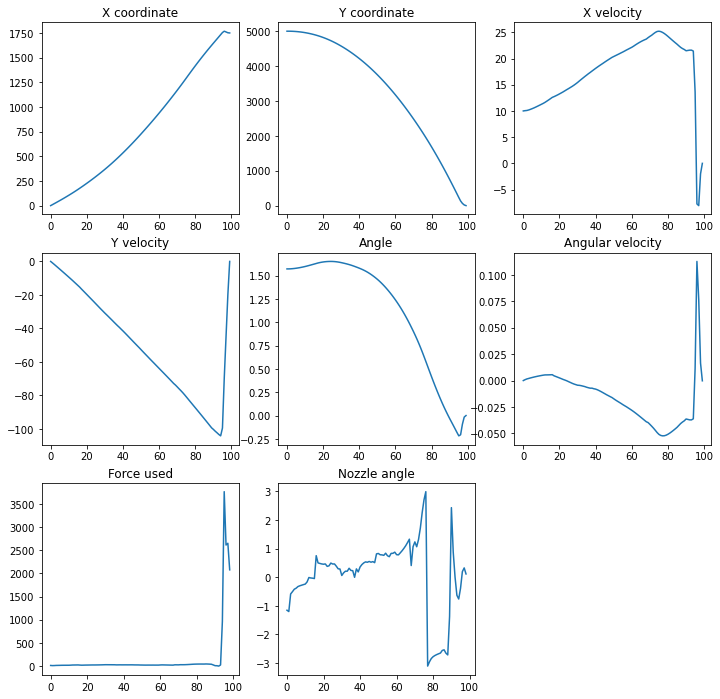

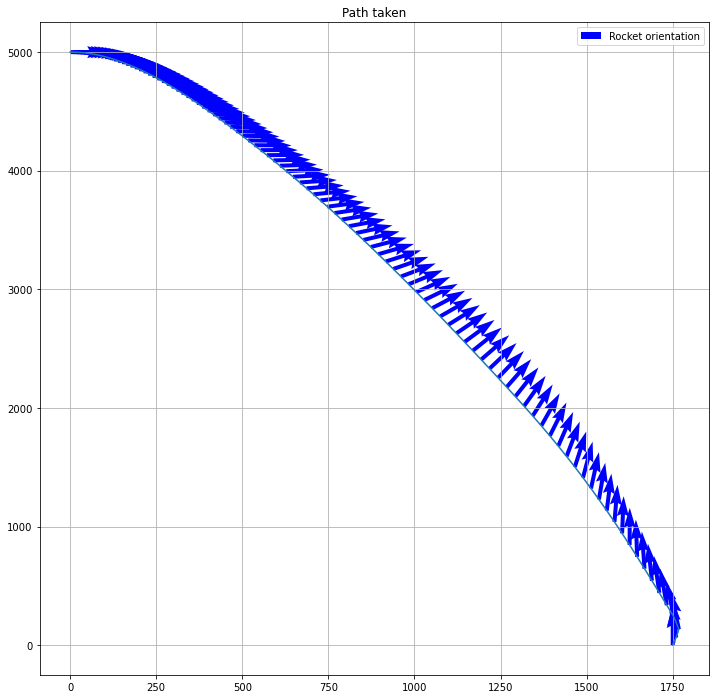

In [12]:
# Set initial guess
u_guess=np.zeros((T-1,n))
u_guess[:,0]=20

# Set number of iterations
iters=50
x_s,u_s=solve_mpc(x0,iters,T,verbal=False,u_guess=u_guess)
print(cost(x_s,u_s,T))
plot(x_s,u_s)
plotpath(x_s,u_s)

# Below is control of a simpler nonlinear system (swinging pendulum) used for debugging

## Initialize parameters of problem

In [5]:
T=100
h=.1

mass=1

m=2
n=1

#state is [x,xdot]
x0=np.array([0,0])
target=np.array([np.pi/2,0])
  
Q=10**6*np.eye(m)
R=100*np.eye(n)

## Functions

In [6]:
def step(x,u):
    x1=np.copy(x)

    x1[0]+=h*x[1]
    x1[1]+=(h/mass)*u+h*10*np.sin(x[0])
    return after_step(x1)
def after_step(x):
    x[0]=np.arctan2(np.sin(x[0]),np.cos(x[0]))
    return x
def linearize(x,u):
    A=np.eye(m)
    B=np.zeros((m,n))
    
    A[0,1]=h
    A[1,0]=h*10*np.cos(x[0])
    B[1,0]=h/mass
    return A,B,R
def forwardpass(oldx_s,oldu_s,control_list,alpha=1,initial=False):
    x_s=np.zeros((T,m))
    x_s[0]=oldx_s[0]
    u_s=np.zeros((T-1,n))
    
    for i in range(T-1):
        K,Kv,v,Ku=control_list[i]
        if initial:
            u_s[i]=oldu_s[i]
        else:
            u_s[i]=oldu_s[i]-np.dot(K,x_s[i]-oldx_s[i])-alpha*np.dot(Kv,v)-alpha*np.dot(Ku,oldu_s[i])
        x_s[i+1]=step(x_s[i],u_s[i])
    return x_s,u_s
def backpass(x_s,u_s):
    S=np.zeros((T,m,m))
    v=np.zeros((T,m))
    K=np.zeros((T-1,n,m))
    Kv=np.zeros((T-1,n,m))
    Ku=np.zeros((T-1,n,n))
    
    control_list=[]
    for i in range(T-1,-1,-1):
        if i==T-1:
            S[i]=Q
            v[i]=np.dot(Q,x_s[i]-target)
        else:
            A,B,R=linearize(x_s[i],u_s[i])
            factor = np.linalg.inv(B.T@S[i+1]@B+R)
            K[i]=factor@B.T@S[i+1]@A
            Kv[i]=factor@B.T
            Ku[i]=factor@R
            S[i]=A.T@S[i+1]@(A-B@K[i])
            v[i]=np.dot((A-B@K[i]).T,v[i+1])-np.dot(K[i].T@R,u_s[i])
            control_list.insert(0,(K[i],Kv[i],v[i+1],Ku[i]))
    return control_list
def cost(x_s,u_s):
    cost=(x_s[-1]-target).T@Q@(x_s[-1]-target)
    for i in range(T-1):
        cost += u_s[i].T@R@u_s[i]
    return cost
def adjust_control_list(control_list,alpha):
    N=len(control_list)
    new_control_list=[]
    for i in range(N):
        new_control_list.append((control_list[i][0],alpha*control_list[i][1],control_list[i][2],alpha*control_list[i][3]))
    return new_control_list
def solve(x0,iters,verbal=False):
    x_s=np.zeros((T,m))
    x_s[0]=x0
    control_list = [(np.zeros((n,m)), np.zeros((n,m)),np.zeros(m),np.zeros((n,n))) for _ in range(T-1)]
    u_s=np.zeros((T-1,n))
    
    #initial input guess
    
    for i in range(iters):
        current_cost=cost(x_s,u_s)
        alpha=1
        x_s,u_s=forwardpass(x_s,u_s,control_list,alpha=alpha,initial=(i==0))
        control_list=backpass(x_s,u_s)
        
        newx_s,newu_s=forwardpass(x_s,u_s,control_list,alpha=alpha)
        while(current_cost<cost(newx_s,newu_s) and alpha>=10**-9):
            alpha/=2
            newx_s,newu_s=forwardpass(x_s,u_s,control_list,alpha=alpha)
        control_list=adjust_control_list(control_list,alpha)
        if verbal:
            print(cost(x_s,u_s))
    x_s,u_s=forwardpass(x_s,u_s,control_list)
    return control_list,x_s,u_s

def plot(x_s,u_s):
    fig=plt.figure(figsize=(15,10))
    rows=2
    columns=3

    fig.add_subplot(rows,columns,1)
    plt.plot(x_s[:,0])
    plt.title("Angle")

    fig.add_subplot(rows,columns,2)
    plt.plot(x_s[:,1])
    plt.title("Angular velocity")

    fig.add_subplot(rows,columns,3)
    plt.plot(u_s[:,0])
    plt.title("Torque")
    
    fig.add_subplot(rows,columns,4)
    plt.scatter(np.sin(x_s[:,0]),np.cos(x_s[:,0]))
    plt.grid()
    plt.xlim(-1.2,1.2)
    plt.ylim(-1.2,1.2)
    plt.title("Path")

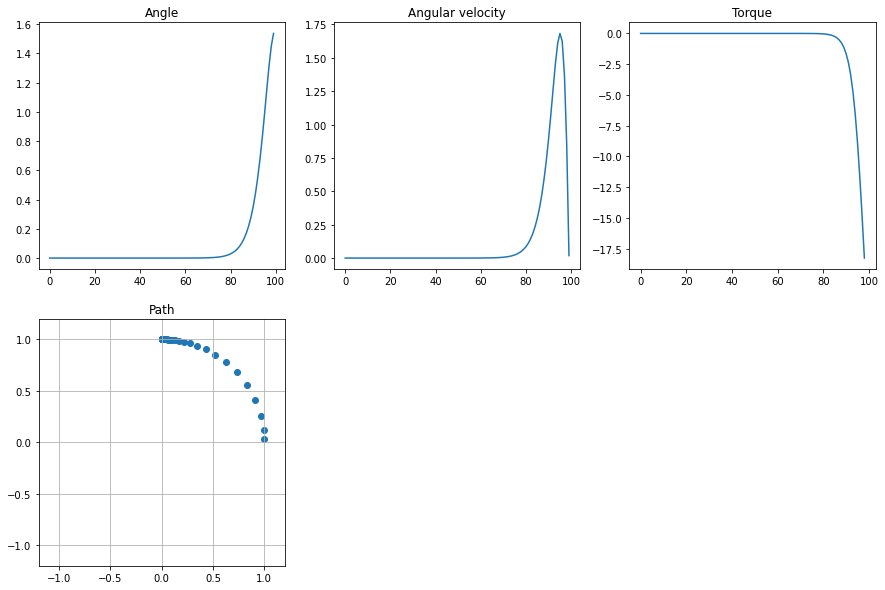

In [7]:
iters=100
control_list,x_s,u_s=solve(x0,iters,False)
plot(x_s,u_s)